# Introduction

Handling missing values in (categorical or continuous) attributes is a core part of a data preprocessing pipeline in Machine Learning. This notebook presents some techniques to deal with missing values. 

# Handling Missing Values on Categorical Attributes

In [103]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


In [105]:
# Identify categorical columns with missing values

cols_with_missing = ["workclass", "occupation", "native-country"]

print(df[cols_with_missing].isna().sum())
print()
print(df[cols_with_missing].nunique())

workclass         2799
occupation        2809
native-country     857
dtype: int64

workclass          8
occupation        14
native-country    41
dtype: int64


We can notice there are some missing values in `workclass`, `native-country` and `occupation`.

<center>

| Column           | Missing Values (approx) |
| ---------------- | ----------------------- |
| `workclass`      | \2799                  |
| `occupation`     | \~2809                  |
| `native-country` | \~857                   |

</center>



Below are some estrategies to handle missing values in categorical columns. Examples are provided in the contexto of the Adult dataset.

## 1. **Drop rows with missing values**

```python
df_clean = df.dropna()
```

* ✔️ Simple and clean.
* ❌ Discards \~6% of the dataset.
* Best when you're okay with losing some data.

---

## 2. **Replace missing values with a special category (e.g., `"Missing"`)**

Recommended for **categorical columns**.

```python
for col in ["workclass", "occupation", "native-country"]:
    df[col] = df[col].cat.add_categories("Missing").fillna("Missing")
```

* ✔️ Preserves all rows.
* ✔️ Allows the model to treat "missingness" as a signal.
* ❌ Adds extra category — may affect cardinality-sensitive models.

---

## 3. **Impute with the most frequent value (mode)**

```python
for col in ["workclass", "occupation", "native-country"]:
    mode = df[col].mode()[0]
    df[col] = df[col].fillna(mode)
```

* ✔️ Keeps the dataset size intact.
* ❌ May distort category frequencies.
* ❌ Assumes missing values are random — which may not hold true.

---

## Which to Choose?

| Goal                                    | Suggested Strategy          |
| --------------------------------------- | --------------------------- |
| Quick and clean baseline                | Drop rows (`dropna`)        |
| Retain all data and model missingness   | Add `"Missing"` as category |
| Avoid new categories and keep structure | Use most frequent (mode)    |
| Planning to use one-hot encoding        | Prefer `"Missing"` strategy |

## Example Code 

The code below shows how to implement of the above described strategies, namely *Handling Missing Categorical Values with "Missing" Category*.

In [106]:
import pandas as pd
from sklearn.datasets import fetch_openml

# Load dataset
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame

# Identify categorical columns with missing values
cols_with_missing = ["workclass", "occupation", "native-country"]

# Replace "?" with actual NaN values (in case it's still coded as string)
df.replace("?", pd.NA, inplace=True)

# Ensure columns are of categorical type (if not already)
for col in cols_with_missing:
    df[col] = df[col].astype("category")

# Add "Missing" category and fill NaNs
for col in cols_with_missing:
    df[col] = df[col].cat.add_categories("Missing").fillna("Missing")

# Check result
print(df[cols_with_missing].isna().sum())  # should all be 0
print()
print(df[cols_with_missing].nunique())     # includes "Missing"


workclass         0
occupation        0
native-country    0
dtype: int64

workclass          9
occupation        15
native-country    42
dtype: int64


# Handling Missing Values on Continuous Attributes

Several strategies exist to handle missing values on continuous (numerical) attributes, each with trade-offs depending on your goals (speed, bias, interpretability, etc.).

### 1. **Drop rows or columns**

* **Use when:** few missing values or when the column isn't critical.
* ✔️ simple, avoids imputation bias.
* ❌ loses data; may remove important patterns.

```python
    df.dropna(subset=["feature1"])
```

---

### 2. **Fill with a constant value**

* Common: 0, -1, or a sentinel value (e.g., `9999`).
* **Use when:** missingness itself may carry meaning.

```python
    df["feature1"] = df["feature1"].fillna(-1)
```

* ❌ may introduce artificial spikes in the distribution.

---

### 3. **Mean / Median / Mode imputation**

* **Mean**: common default; best if data is symmetric and missing at random.
* **Median**: more robust to outliers (recommended in general).
* **Mode**: useful in ordinal features with discrete values.

```python
    df["feature1"].fillna(df["feature1"].mean(), inplace=True)
```

---

### 4. **K-Nearest Neighbors (KNN) imputation**

* Imputes a value based on the average of **k most similar rows**.
* **Captures local structure** better than global mean/median.

```python
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = imputer.fit_transform(df)
```

* ❌ slower; sensitive to feature scaling.

---

### 5. **Multivariate Imputation by Chained Equations (MICE)**

* Uses **regression models** to predict missing values from other features iteratively.

```python
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

    imp = IterativeImputer(random_state=0)
    df_imputed = imp.fit_transform(df)
```

* ✔️ leverages correlations between variables.
* ❌ computationally expensive; can overfit if not regularized.

---

### 6. **Predictive models (custom regressors)**

* Train a regression model (e.g., linear or XGBoost) using non-missing rows to predict missing values.
* Works well when the variable has strong predictors.

---

### 7. **Use a missing indicator as a feature**

* Combine with any imputation:

```python
    df["feature1_missing"] = df["feature1"].isna().astype(int)
    df["feature1"] = df["feature1"].fillna(df["feature1"].median())
```

* Helps the model "know" that a value was imputed.

---

## Which to choose?

| Situation                               | Recommended Strategy                               |
| --------------------------------------- | -------------------------------------------------- |
| Simple and robust                       | Median imputation + indicator                      |
| Small dataset, no strong correlations   | Median or KNN                                      |
| Data has strong correlations            | MICE or predictive modeling                        |
| You want simplicity or interpretability | Mean/median                                        |
| You use tree-based models               | Median + indicator (trees handle missingness well) |


# Example Code

In [107]:
import pandas as pd

# Load dataset
df_melb_data = pd.read_csv("../data/melb_data.csv")
X = df_melb_data.drop("Price", axis=1)
y = df_melb_data["Price"]

In [108]:
df_melb_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [109]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Method         13580 non-null  object 
 5   SellerG        13580 non-null  object 
 6   Date           13580 non-null  object 
 7   Distance       13580 non-null  float64
 8   Postcode       13580 non-null  float64
 9   Bedroom2       13580 non-null  float64
 10  Bathroom       13580 non-null  float64
 11  Car            13518 non-null  float64
 12  Landsize       13580 non-null  float64
 13  BuildingArea   7130 non-null   float64
 14  YearBuilt      8205 non-null   float64
 15  CouncilArea    12211 non-null  object 
 16  Lattitude      13580 non-null  float64
 17  Longtitude     13580 non-null  float64
 18  Region

<Axes: >

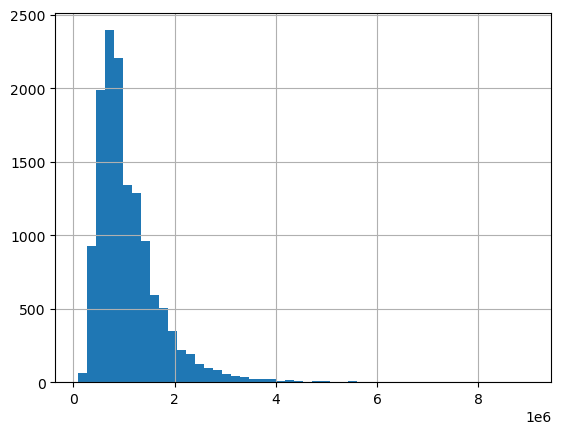

In [110]:
y.hist(bins=50)

<Axes: >

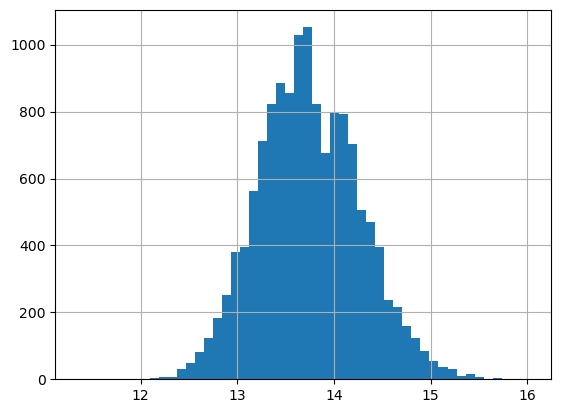

In [111]:
import numpy as np
# Log-transform the target
y_log = np.log1p(y)
y_log.hist(bins=50)

In [112]:
# Identify categorical columns with missing values

cols_with_missing = ["BuildingArea", "YearBuilt", "CouncilArea"]

# Print the number of missing values in each column
print(X[cols_with_missing].isna().sum())

BuildingArea    6450
YearBuilt       5375
CouncilArea     1369
dtype: int64


In [113]:
# ATENTION! Ignore categorical columns for simplicity
X_num = X.select_dtypes(include=[np.number])

In [114]:
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          13580 non-null  int64  
 1   Distance       13580 non-null  float64
 2   Postcode       13580 non-null  float64
 3   Bedroom2       13580 non-null  float64
 4   Bathroom       13580 non-null  float64
 5   Car            13518 non-null  float64
 6   Landsize       13580 non-null  float64
 7   BuildingArea   7130 non-null   float64
 8   YearBuilt      8205 non-null   float64
 9   Lattitude      13580 non-null  float64
 10  Longtitude     13580 non-null  float64
 11  Propertycount  13580 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.2 MB


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from scipy.stats import sem, t

# Define strategies
strategies = {
    "Drop Rows": None,
    "Mean": SimpleImputer(strategy="mean"),
    "Median": SimpleImputer(strategy="median"),
    "KNN (k=5)": KNNImputer(n_neighbors=5),
    "MICE (Iterative)": IterativeImputer(random_state=0)
}

N_RUNS = 10
results = {name: {"rmse": [], "mae": []} for name in strategies}

# Repeat experiment with multiple seeds
for seed in range(N_RUNS):
    rng = np.random.RandomState(seed)

    y_log = np.log1p(y)  # log-transformed target

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_num, y_log, test_size=0.3, random_state=seed)
    _, _, y_train_orig, y_test_orig = train_test_split(X_num, y, test_size=0.3, random_state=seed)

    for name, imputer in strategies.items():
        if name == "Drop Rows":
            X_tr = X_train.dropna()
            y_tr = y_train[X_tr.index]
            y_tr_orig = y_train_orig[X_tr.index]

            X_te = X_test.dropna()
            y_te = y_test[X_te.index]
            y_te_orig = y_test_orig[X_te.index]

            model = make_pipeline(StandardScaler(), XGBRegressor(random_state=seed, verbosity=0))
            model.fit(X_tr, y_tr)
            y_pred = np.expm1(model.predict(X_te))

            rmse = np.sqrt(mean_squared_error(y_te_orig, y_pred))
            mae = mean_absolute_error(y_te_orig, y_pred)

        elif name == "KNN (k=5)":
            # Scale before KNN Imputer
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            imputer_knn = KNNImputer(n_neighbors=5)
            X_train_imp = imputer_knn.fit_transform(X_train_scaled)
            X_test_imp = imputer_knn.transform(X_test_scaled)

            model = XGBRegressor(random_state=seed, verbosity=0)
            model.fit(X_train_imp, y_train)
            y_pred = np.expm1(model.predict(X_test_imp))

            rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
            mae = mean_absolute_error(y_test_orig, y_pred)

        else:
            model = make_pipeline(imputer, StandardScaler(), XGBRegressor(random_state=seed, verbosity=0))
            model.fit(X_train, y_train)
            y_pred = np.expm1(model.predict(X_test))

            rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
            mae = mean_absolute_error(y_test_orig, y_pred)

        results[name]["rmse"].append(rmse)
        results[name]["mae"].append(mae)

# Aggregate metrics with 95% confidence intervals
summary = []
for name, scores in results.items():
    for metric in ["rmse", "mae"]:
        vals = np.array(scores[metric])
        mean = vals.mean()
        ci = t.ppf(0.975, df=N_RUNS-1) * sem(vals)
        summary.append((name, metric.upper(), mean, ci))

df_summary = pd.DataFrame(summary, columns=["Strategy", "Metric", "Mean", "95% CI"])
print(df_summary.pivot(index="Strategy", columns="Metric", values=["Mean", "95% CI"]))

/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/ebezerra/anaconda3/envs/cic120

                           Mean                      95% CI              
Metric                      MAE           RMSE          MAE          RMSE
Strategy                                                                 
Drop Rows         162537.656164  300544.631800  3883.660033  19050.376240
KNN (k=5)         170065.694837  295731.076295  2587.825452  12320.352325
MICE (Iterative)  170203.026853  297567.729506  3062.604589  12434.149683
Mean              169843.369657  295141.973770  2501.739897  12093.626360
Median            169121.452457  292862.549804  2149.618642  10070.041462


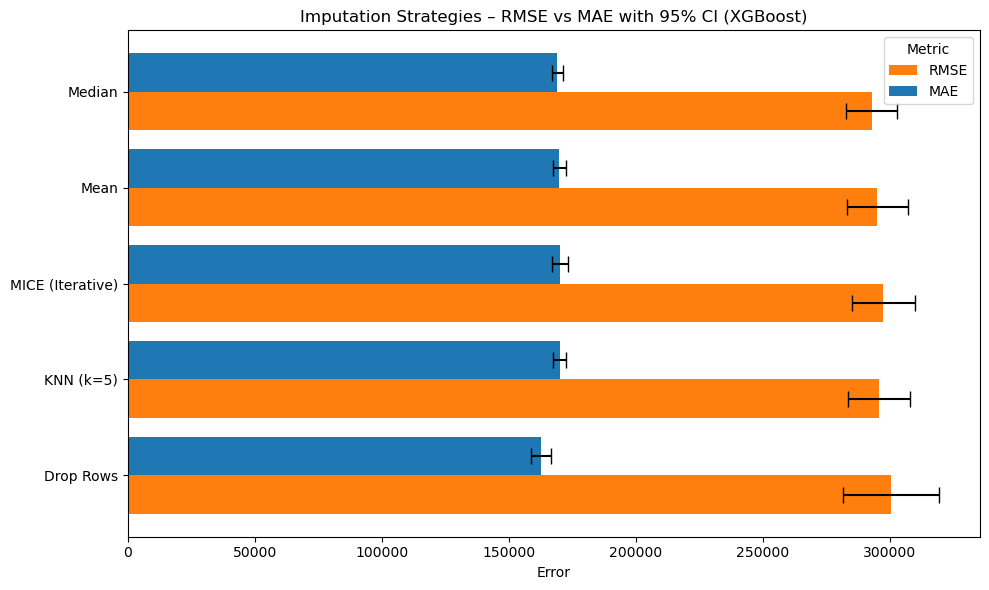

In [116]:
# Get mean and CI separately
df_mean = df_summary.pivot(index="Strategy", columns="Metric", values="Mean")
df_ci = df_summary.pivot(index="Strategy", columns="Metric", values="95% CI")

# Plot manually with error bars
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
index = np.arange(len(df_mean))

metrics = ["RMSE", "MAE"]
colors = ["tab:orange", "tab:blue"]

for i, metric in enumerate(metrics):
    means = df_mean[metric].values
    cis = df_ci[metric].values
    ax.barh(
        index + i * bar_width,
        means,
        xerr=cis,
        height=bar_width,
        label=metric,
        color=colors[i],
        capsize=6
    )

ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(df_mean.index)
ax.set_xlabel("Error")
ax.set_title("Imputation Strategies – RMSE vs MAE with 95% CI (XGBoost)")
ax.legend(title="Metric")
plt.tight_layout()
plt.show()

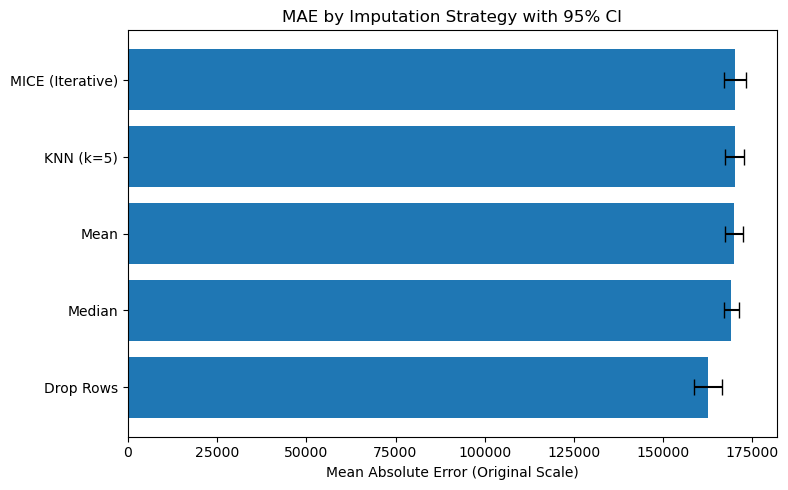

In [117]:
# Filter only MAE entries
df_mae = df_summary[df_summary["Metric"] == "MAE"].set_index("Strategy")
df_mae = df_mae.sort_values("Mean")  # optional sorting

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(
    df_mae.index,
    df_mae["Mean"],
    xerr=df_mae["95% CI"],
    color="tab:blue",
    capsize=6
)

# Formatting
ax.set_xlabel("Mean Absolute Error (Original Scale)")
ax.set_title("MAE by Imputation Strategy with 95% CI")
plt.tight_layout()
plt.show()


# Final Remarks

## Imputation bias

**Imputation bias** occurs when the method used to fill in missing values systematically **alters the statistical properties** of the data — such as the mean, variance, or distribution — leading to **distorted inferences or model behavior**.

For example, filling all missing values with the **mean** reduces the variance of the feature, which can bias model coefficients or decision boundaries.

> **Key Point:** Imputation bias arises not from the missing data itself, but from **how** it's filled — especially when the missingness is **not random** or when simplistic imputations (e.g., mean) are applied blindly.


## Types of Missingness

There are situations where the fact that a value is missing is **not independent** of the data itself. This is a key concept in understanding how missing data can introduce bias.

There are **three standard types** of missingness, which are summarized below.

---

### 1. **MCAR – Missing Completely at Random**

The probability of a value being missing is **independent** of all observed and unobserved data.

*Example:* A survey response is lost due to a data storage error.

> Safe to use simple imputations like mean/median — no bias introduced.

---

### 2. **MAR – Missing at Random**

The missingness depends **only on other observed variables**, not on the missing value itself.

*Example:* Income is missing more often for younger participants, but not related to the actual income value.

> Can be handled with techniques like **MICE** or **model-based imputation**.

---

### 3. **MNAR – Missing Not at Random**

The missingness depends on **the unobserved value itself**. It may or may not depend on observed variables, but it definitely depends on the missing value itself, and that’s what makes it problematic.

*Example:* People with very high income are more likely to leave the income question blank.

> Most dangerous: standard imputations may introduce **strong bias**, because the act of missingness reveals something about the missing value.

---

### Summary

| Type     | Depends on observed data? | Depends on missing value? | Risk of bias |
| -------- | ------------------------- | ------------------------- | ------------ |
| **MCAR** | No                        | No                        | Low          |
| **MAR**  | Yes                       | No                        | Moderate     |
| **MNAR** | Maybe                     | Yes                       | High         |

A legend to help understand the table below:

| Column                        | Meaning                                                             |
| ----------------------------- | ------------------------------------------------------------------- |
| Depends on **observed data**? | Does the missingness depend on other known (non-missing) variables? |
| Depends on **missing value**? | Does the missingness depend on the actual value that is missing?    |